In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from abc import ABC, abstractmethod
from typing import Optional
import unittest

In [2]:



#############################
# core/data_logger.py
class DataLogger:
    def __init__(self):
        self.data = {
            'mid_prices': [],
            'bid_prices': [],
            'ask_prices': [],
            'reservation_prices': [],
            'inventory': [],
            'cash': [],
            'wealth': []
        }
    def log(self, key: str, value):
        self.data[key].append(value)
    def get_dataframe(self):
        return pd.DataFrame(self.data)


#############################
# core/inventory_manager.py
class InventoryManager:
    def __init__(self, initial_cash: float, initial_inventory: int):
        self.cash = initial_cash
        self.inventory = initial_inventory
    def update(self, delta_inventory: int, delta_cash: float):
        self.inventory += delta_inventory
        self.cash += delta_cash


#############################
# core/market_simulator.py
class MarketSimulator(ABC):
    @abstractmethod
    def simulate(self, steps: int) -> np.ndarray:
        """Simulate mid-prices and return an array of prices."""
        pass


#############################
# core/order_execution.py
class OrderExecution(ABC):
    @abstractmethod
    def execute_orders(
        self,
        bid_price: float,
        ask_price: float,
        inventory: int,
        cash: float,
        dt: float
    ) -> tuple[int, float]:
        """Return updated (inventory, cash) after order execution."""
        pass


#############################
# core/pricing_strategy.py
class PricingStrategy(ABC):
    @abstractmethod
    def calculate_reservation_price(self, current_price: float, inventory: int, time_remaining: float) -> float:
        pass
    @abstractmethod
    def calculate_spread(self, current_price: float, inventory: int, time_remaining: float) -> tuple[float, float]:
        """Return (bid_spread, ask_spread) relative to reservation price."""
        pass


#############################
# core/simulation_runner.py
# core/simulation_runner.py
class SimulationRunner:
    def __init__(self, market, pricing_strategy, order_execution, inventory, logger, dt: float, T: float):
        self.market = market
        self.strategy = pricing_strategy
        self.execution = order_execution
        self.inventory = inventory
        self.logger = logger
        self.dt = dt
        self.T = T
        self.steps = int(T / dt)
    def run(self):
        mid_prices = self.market.simulate(self.steps)
        for i in range(self.steps):
            t = i * self.dt
            time_remaining = self.T - t
            current_price = mid_prices[i]
            inventory_level = self.inventory.inventory
            cash = self.inventory.cash
            # Get pricing from strategy
            reservation_price = self.strategy.calculate_reservation_price(
                current_price=mid_prices[i],
                inventory=self.inventory.inventory,
                time_remaining=time_remaining
            )
            bid_spread, ask_spread = self.strategy.calculate_spread(
                current_price=mid_prices[i],
                inventory=self.inventory.inventory,
                time_remaining=time_remaining
            )
            # Calculate absolute prices
            bid_price = reservation_price - bid_spread
            ask_price = reservation_price + ask_spread

            
            bid_price = reservation_price - bid_spread
            ask_price = reservation_price + ask_spread

            # Execution
            new_inventory, new_cash = self.execution.execute_orders(
                bid_price=bid_price,
                ask_price=ask_price,
                inventory=inventory_level,
                cash=cash,
                dt=self.dt
            )
            self.inventory.update(new_inventory - inventory_level, new_cash - cash)
            wealth = self.inventory.cash + self.inventory.inventory*mid_prices[i]
            # Log data
            self.logger.log('mid_prices', mid_prices[i])
            self.logger.log('reservation_prices', reservation_price)
            self.logger.log('bid_prices', bid_price)
            self.logger.log('ask_prices', ask_price)
            self.logger.log('inventory', self.inventory.inventory)
            self.logger.log('cash', self.inventory.cash)
            self.logger.log('wealth', wealth)


#############################



#############################
# executions/poisson_execution.py
class PoissonOrderExecution(OrderExecution):
    def __init__(self, A: float, k: float):
        self.A = A
        self.k = k
    def execute_orders(self, bid_price: float, ask_price: float, inventory: int, cash: float, dt: float) -> tuple[
        int, float]:
        # Simplified Poisson execution logic
        lambda_bid = self.A * np.exp(-self.k * (ask_price - bid_price) / 2)
        lambda_ask = self.A * np.exp(-self.k * (ask_price - bid_price) / 2)
        if np.random.rand() < lambda_bid * dt:
            cash -= bid_price
            inventory += 1
        if np.random.rand() < lambda_ask * dt:
            cash += ask_price
            inventory -= 1
        return inventory, cash


#############################
class PoissonExecutionAbm(OrderExecution):
    def __init__(self, A: float, k: float):
        self.A = A
        self.k = k
    def execute_orders(
        self,
        bid_price: float,
        ask_price: float,
        inventory: int,
        cash: float,
        dt: float
    ) -> tuple[int, float]:
        spread = ask_price - bid_price
        lambda_bid = self.A * np.exp(-self.k * spread)
        lambda_ask = self.A * np.exp(-self.k * spread)
        if np.random.rand() < lambda_bid * dt:
            cash -= bid_price
            inventory += 1
        if np.random.rand() < lambda_ask * dt:
            cash += ask_price
            inventory -= 1
        return inventory, cash


#############################
class PoissonExecutionGbm(OrderExecution):
    def __init__(self, A: float, k: float):
        self.A = A
        self.k = k
    def execute_orders(
        self,
        bid_price: float,
        ask_price: float,
        inventory: int,
        cash: float,
        dt: float
    ) -> tuple[int, float]:
        spread = ask_price - bid_price
        lambda_bid = self.A * np.exp(-self.k * spread)
        lambda_ask = self.A * np.exp(-self.k * spread)
        if np.random.rand() < lambda_bid * dt:
            cash -= bid_price
            inventory += 1
        if np.random.rand() < lambda_ask * dt:
            cash += ask_price
            inventory -= 1
        return inventory, cash


#############################


#############################
# simulations/arithmetic_brownian.py
class ArithmeticBrownianMotion(MarketSimulator):
    """
    A class to simulate a price path using Arithmetic Brownian Motion (ABM).
    ABM models the evolution of asset prices using a linear stochastic differential equation:
    S(t+1) = S(t) + sigma * sqrt(dt) * Z,
    where Z is a standard normal random variable.
    Attributes:
        NoOfSteps (int): Number of time steps in the simulation.
        S0 (float): Initial asset price.
        sigma (float): Volatility coefficient (standard deviation).
    """
    def __init__(self, S0: float, sigma: float, NoOfSteps: Optional[int] = None):
        """
        Initializes the ABM simulator with the given parameters.
        Args:
            NoOfSteps (int): Number of steps in the simulation.
            S0 (float): Initial price level.
            sigma (float): Volatility of the price process.
        """
        self.S0 = S0
        self.sigma = sigma
        self.NoOfSteps = NoOfSteps
    def simulate(self) -> np.ndarray:
        """
        Runs the simulation of Arithmetic Brownian Motion.
        Returns:
            np.ndarray: Simulated path of asset prices as a NumPy array.
        """
        dt = 1 / self.NoOfSteps
        S = np.zeros(self.NoOfSteps + 1)  # Initialize price array
        S[0] = self.S0  # Set initial price
        Z = np.random.normal(0, 1, self.NoOfSteps)  # Generate standard normal random variables
        # Generate the price path
        for i in range(1, self.NoOfSteps + 1):
            S[i] = S[i - 1] + self.sigma * np.sqrt(dt) * Z[i - 1]
        return S
    def simulate(self, steps: int) -> np.ndarray:
        """
        Runs the simulation of Arithmetic Brownian Motion.
        Returns:
            np.ndarray: Simulated path of asset prices as a NumPy array.
        """
        dt = 1 / steps
        S = np.zeros(steps + 1)  # Initialize price array
        S[0] = self.S0  # Set initial price
        Z = np.random.normal(0, 1, steps)  # Generate standard normal random variables
        # Generate the price path
        for i in range(1, steps + 1):
            S[i] = S[i - 1] + self.sigma * np.sqrt(dt) * Z[i - 1]
        return S


#############################
class GeometricBrownianMotion(MarketSimulator):
    """ A class to simulate asset prices using Geometric Brownian Motion (GBM).
    GBM models the asset price evolution using the exponential of a Brownian motion:
    S(t+1) = S(t) * exp((μ - 0.5 * σ²) * dt + σ * sqrt(dt) * Z)
    Here, μ is assumed to be 0 for simplicity (no drift).
    Attributes:
        NoOfSteps (int): Number of time steps in the simulation.
    S0 (float): Initial asset price.
    sigma (float): Volatility of the asset.
    """
    def __init__(self, S0: float, sigma: float, NoOfSteps: Optional[int] = None):
        """
        Initializes the GBM simulator with the provided parameters.
        Args : 
        NoOfSteps (int): Number of discrete time steps.
        S0 (float): Initial price of the asset.
        sigma (float): Volatility (standard deviation of returns).
        """ 
        self.NoOfStep = NoOfSteps
        self.S0 = S0
        self.sigma = sigma
    def simulate(self) -> np.ndarray:
        """
        Runs the Geometric Brownian Motion simulation.
        Returns:
        np.ndarray: Simulated price path as a NumPy array. 
        """
        S = np.zeros(self.NoOfStep + 1) # Array to store simulated prices
        S[0] = self.S0 # Set initial price
        dt = 1 / self.NoOfStep # Time step size
        Z = np.random.normal(0, 1, self.NoOfStep) # Standard normal random variables
        # Generate price path
        for i in range(1, self.NoOfStep + 1):
            # GBM price update formula
            S[i] = S[i - 1] * np.exp((-0.5 * self.sigma**2) * dt + self.sigma * Z[i - 1] * np.sqrt(dt))
        return S
    def simulate(self, steps: int) -> np.ndarray:
        """
        Runs the Geometric Brownian Motion simulation.
        Returns:
        np.ndarray: Simulated price path as a NumPy array.
        """
        S = np.zeros(steps + 1) # Array to store simulated prices
        S[0] = self.S0 # Set initial price
        dt = 1 / steps # Time step size
        Z = np.random.normal(0, 1, steps) # Standard normal random variables
        # Generate price path
        for i in range(1, steps + 1):
            # GBM price update formula
            S[i] = S[i - 1] * np.exp((-0.5 * self.sigma**2) * dt + self.sigma * Z[i - 1] * np.sqrt(dt))
        return S


#############################


#############################
class AsymmetricAvellanedaStoikovStrategy(PricingStrategy):
    def __init__(self, gamma: float, sigma: float, kappa: float):
        self.gamma = gamma
        self.sigma = sigma
        self.kappa = kappa
    def calculate_reservation_price(self,
                                    current_price: float,
                                    inventory: int,
                                    time_remaining: float) -> float:
        return current_price - inventory * self.gamma * (self.sigma ** 2) * time_remaining
    def calculate_spreads(self,
                          current_price: float,
                          inventory: int,
                          time_remaining: float) -> tuple[float, float]:
        # Inventory risk component
        inventory_risk = self.gamma * (self.sigma ** 2) * time_remaining
        # Execution probability component
        execution_term = (1 / self.gamma) * np.log(1 + self.gamma / self.kappa)
        # Asymmetric spread calculation
        delta_bid = ((1 + 2 * inventory) * inventory_risk) / 2 + execution_term
        delta_ask = ((1 - 2 * inventory) * inventory_risk) / 2 + execution_term
        return delta_bid, delta_ask

#############################
class AvellanedaStoikovStrategyAbm(PricingStrategy):
    def __init__(self, gamma: float, sigma: float, k: float):
        """
        Args:
            gamma (float): Risk aversion coefficient.
            sigma (float): Volatility.
            k (float): Market depth parameter.
        """
        self.gamma = gamma
        self.k = k
        self.sigma = sigma
    def calculate_reservation_price(self, current_price: float, inventory: int, time_remaining: float) -> float:
        return current_price - inventory * self.gamma * self.sigma**2 * time_remaining
    def calculate_spread(self, current_price: float, inventory: int, time_remaining: float) -> tuple[float, float]:
        spread = self.gamma * self.sigma**2 * time_remaining
        spread += (2 / self.gamma) * np.log(1 + self.gamma / self.k)
        return (spread + 2*inventory*self.gamma * self.sigma**2 * time_remaining)/ 2, (spread - 2*inventory*self.gamma * self.sigma**2 * time_remaining)/ 2  # bid_spread, ask_spread 


#############################
class AvellanedaStoikovStrategyGbm(PricingStrategy):
    def __init__(self, gamma: float, sigma: float, k: float):
        """
        Args:
            gamma (float): Risk aversion coefficient.
            sigma (float): Volatility.
            k (float): Market depth parameter.
        """
        self.gamma = gamma
        self.k = k
        self.sigma = sigma
    def calculate_reservation_price(self, current_price, inventory, time_remaining):
        return current_price - inventory * self.gamma * self.sigma**2 * time_remaining
    def calculate_spread(self, current_price, inventory, time_remaining):
        spread = self.gamma * self.sigma**2 * time_remaining
        spread += (2 / self.gamma) * np.log(1 + self.gamma / self.k)
        return spread / 2, spread / 2

#############################
# strategies/avellaneda_stoikov.py
class SymmetricStrategy(PricingStrategy):
    def __init__(self, gamma: float, sigma: float, k: float):
        self.gamma = gamma
        self.sigma = sigma
        self.k = k
    def calculate_reservation_price(self, current_price: float, inventory: int, time_remaining: float) -> float:
        # Ignores inventory: just returns the mid-price because the 
        # reservation price is always equal to the mid-price, regardless of inventory.
        return current_price
    def calculate_spread(self, current_price: float, inventory: int, time_remaining: float) -> tuple[float, float]:
        # Uses the same spread formula as Avellaneda-Stoikov
        spread = self.gamma * (self.sigma ** 2) * time_remaining + (2 / self.gamma) * np.log(1 + self.gamma / self.k)
        return (spread / 2, spread / 2)
        #return (1.29 / 2, 1.29 / 2)


#############################


#############################
class TestPricingStrategies(unittest.TestCase):
    def setUp(self):
        self.current_price = 100.0
        self.inventory = 10
        self.time_remaining = 1.0
        self.gamma = 0.1
        self.sigma = 2.0
        self.k = 1.5
        self.astoikov = AvellanedaStoikovStrategyABM(
            gamma=self.gamma,
            sigma=self.sigma,
            k=self.k
        )
        self.symmetric = SymmetricStrategy(
            gamma=self.gamma,
            sigma=self.sigma,
            k=self.k
        )
    def test_avellaneda_reservation_price(self):
        expected_price = self.current_price - self.inventory * self.gamma * (self.sigma ** 2) * self.time_remaining
        calculated = self.astoikov.calculate_reservation_price(self.current_price, self.inventory, self.time_remaining)
        self.assertAlmostEqual(calculated, expected_price, places=5)
    def test_avellaneda_spread(self):
        spread = self.gamma * (self.sigma ** 2) * self.time_remaining + (2 / self.gamma) * np.log(1 + self.gamma / self.k)
        bid_spread, ask_spread = self.astoikov.calculate_spread(self.current_price, self.inventory, self.time_remaining)
        self.assertAlmostEqual(bid_spread + ask_spread, spread, places=5)
    def test_symmetric_reservation_price(self):
        calculated = self.symmetric.calculate_reservation_price(self.current_price, self.inventory, self.time_remaining)
        self.assertEqual(calculated, self.current_price)
    def test_symmetric_spread(self):
        spread = self.gamma * (self.sigma ** 2) * self.time_remaining + (2 / self.gamma) * np.log(1 + self.gamma / self.k)
        bid_spread, ask_spread = self.symmetric.calculate_spread(self.current_price, self.inventory, self.time_remaining)
        self.assertAlmostEqual(bid_spread + ask_spread, spread, places=5)



#############################


#############################
def run_strategy(
    simulator, # Class or function to simulate mid-price (ABM or GBM)
    strategy_class, # Class that implements the quoting strategy
    execution_class, # Class that models execution probability (Poisson-based)
    strategy_name, # Label for strategy (used for logging or plotting)
    market_name, # Label for market process (ABM or GBM)
    steps,  # Number of discrete time steps in the simulation
    dt, # Time increment (Δt)
    gamma, # Risk aversion parameter
    k, # Market depth (for execution intensity λ(δ))
    sigma,  # Volatility of the mid-price process
    seed: int = 42
):
    T = steps * dt 
    # Initialize the mid-price process (ABM or GBM) and simulate a price path over steps
    market = simulator(S0=100, sigma=sigma)
    prices = market.simulate(steps)
    # Instantiate the quoting strategy (e.g., Avellaneda-Stoikov), passing in model parameters.
    strategy = strategy_class(gamma=gamma, sigma=sigma, k=k)
    # Create the Poisson-based trade execution model with a base intensity A and decay rate k
    execution = execution_class(A=100, k=k)
    # Start with zero inventory and zero cash. Prepare the logging system to track simulation data.
    inventory = InventoryManager(initial_cash=0, initial_inventory=0)
    logger = DataLogger()
    # Initialize the simulation engine and run it. 
    # This simulates quote placements, executions, and inventory updates over time.
    runner = SimulationRunner(
        market=market,
        pricing_strategy=strategy,
        order_execution=execution,
        inventory=inventory,
        logger=logger,
        dt=dt,
        T=T
    )
    runner.run()
    df = logger.get_dataframe()
    df["pnl"] = df["cash"] + df["inventory"] * df["mid_prices"]
    df["strategy"] = f"{strategy_name} ({market_name})"
    return df
def plot_strategy_diagnostics(df, title="Strategy Behavior"):
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    # 1. Price and Quotes
    axs[0].plot(df["mid_prices"], label="Mid Price")
    axs[0].plot(df["reservation_prices"], label="Reservation Price")
    axs[0].plot(df["bid_prices"], label="Bid Price", linestyle="--")
    axs[0].plot(df["ask_prices"], label="Ask Price", linestyle="--")
    axs[0].set_ylabel("Price")
    axs[0].set_title(f"{title} – Quotes vs Price")
    axs[0].legend()
    axs[0].grid(True)
    # 2. Inventory
    axs[1].plot(df["inventory"], label="Inventory", color="orange")
    axs[1].set_ylabel("Inventory")
    axs[1].set_title("Inventory Over Time")
    axs[1].legend()
    axs[1].grid(True)
    # 3. PnL and Cash
    axs[2].plot(df["pnl"], label="PnL", color="green")
    axs[2].plot(df["cash"], label="Cash", color="purple", linestyle="--")
    axs[2].set_ylabel("PnL / Cash")
    axs[2].set_xlabel("Time Step")
    axs[2].set_title("PnL and Cash Over Time")
    axs[2].legend()
    axs[2].grid(True)
    plt.tight_layout()
    plt.show()
def run_monte_carlo(
    simulator, # Class or function to simulate mid-price (ABM or GBM)
    strategy_class, # Class that implements the quoting strategy
    execution_class, # Class that models execution probability (Poisson-based)
    strategy_name, # Label for strategy (used for logging or plotting)
    market_name, # Label for market process (ABM or GBM)
    steps,  # Number of discrete time steps in the simulation
    dt, # Time increment (Δt)
    gamma, # Risk aversion parameter
    k, # Market depth (for execution intensity λ(δ))
    sigma,  # Volatility of the mid-price process
    n_simulations # Number of Monte Carlo simulations to run
):
    all_results = []
    for i in range(n_simulations):
        df = run_strategy(
            simulator=simulator,
            strategy_class=strategy_class,
            execution_class=execution_class,
            strategy_name=strategy_name,
            market_name=market_name,
            steps=steps,
            dt=dt,
            gamma=gamma,
            k=k,
            sigma=sigma,
            seed=i  
        )
        final = df.iloc[-1]  # take last row (final pnl, inventory, etc.)
        all_results.append(final)
    return pd.DataFrame(all_results)

In [5]:

#############################
# Import helper functions (single run, monte carlo, plotting)
def main():
    # Simulation parameters
    steps = 240           # Number of time steps per simulation
    dt = 1/240.0             # Time increment (Δt)
    gamma = 0.1            # Risk aversion coefficient
    k = 1.5             # Market depth parameter
    sigma = 2.0           # Volatility of the mid-price process
    n_simulations = 1000   # Number of Monte Carlo simulation runs
    # Flags
    show_plots = True   # Whether to show detailed single-run plots
    run_mc = True      # Whether to run Monte Carlo simulation
    # Define different strategies and market models to evaluate
    strategy_configs = [
        {
            "name": "Avellaneda",
            "market": "ABM",
            "simulator": ArithmeticBrownianMotion,
            "strategy_class": AvellanedaStoikovStrategyAbm,
            "execution_class": PoissonExecutionAbm
        },

        {
            "name": "Symmetric",
            "market": "ABM",
            "simulator": ArithmeticBrownianMotion,
            "strategy_class": SymmetricStrategy,
            "execution_class": PoissonExecutionAbm
        }
    ]
    # ----------------------
    # SINGLE-RUN SIMULATION
    # ----------------------
    if show_plots:
        for config in strategy_configs:
            df = run_strategy(
                simulator=config["simulator"],
                strategy_class=config["strategy_class"],
                execution_class=config["execution_class"],
                strategy_name=config["name"],
                market_name=config["market"],
                steps=steps,
                dt=dt,
                gamma=gamma,
                k=k,
                sigma=sigma,
                seed=None
            )
            plot_title = f"{config['name']} ({config['market']})"
            plot_strategy_diagnostics(df, plot_title)
    # ----------------------
    # MONTE CARLO SIMULATION
    # ----------------------
    if run_mc:
        mc_results = []
        for config in strategy_configs:
            # Run N simulations and collect final PnL statistics
            df_mc = run_monte_carlo(
                simulator=config["simulator"],
                strategy_class=config["strategy_class"],
                execution_class=config["execution_class"],
                strategy_name=config["name"],
                market_name=config["market"],
                steps=steps,
                dt=dt,
                gamma=gamma,
                k=k,
                sigma=sigma,
                n_simulations=n_simulations
            )
            mc_results.append(df_mc)
        # Combine results from all strategy configurations
        df_all = pd.concat(mc_results, ignore_index=True)
        # Save the full simulation results (optional)
        df_all.to_csv("Monte_Carlo_Simulation.csv")
        # Plot density curves of final PnLs (one per strategy)
        plt.figure(figsize=(10, 6))
        for label, group in df_all.groupby("strategy"):
            sns.kdeplot(
                group["pnl"],
                label=label,
                fill=False,
                linewidth=2.0,
                alpha=0.4,
                bw_adjust=0.5
            )
        plt.title("Final PnL Distribution (Monte Carlo)")
        plt.xlabel("PnL")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        # Print summary statistics (mean, std, Sharpe ratio)
        summary = df_all.groupby("strategy")["pnl"].agg(["mean", "std"])
        summary["sharpe"] = summary["mean"] / summary["std"]
        print("\nSummary Statistics (Final PnL):")
        print(summary)


#############################

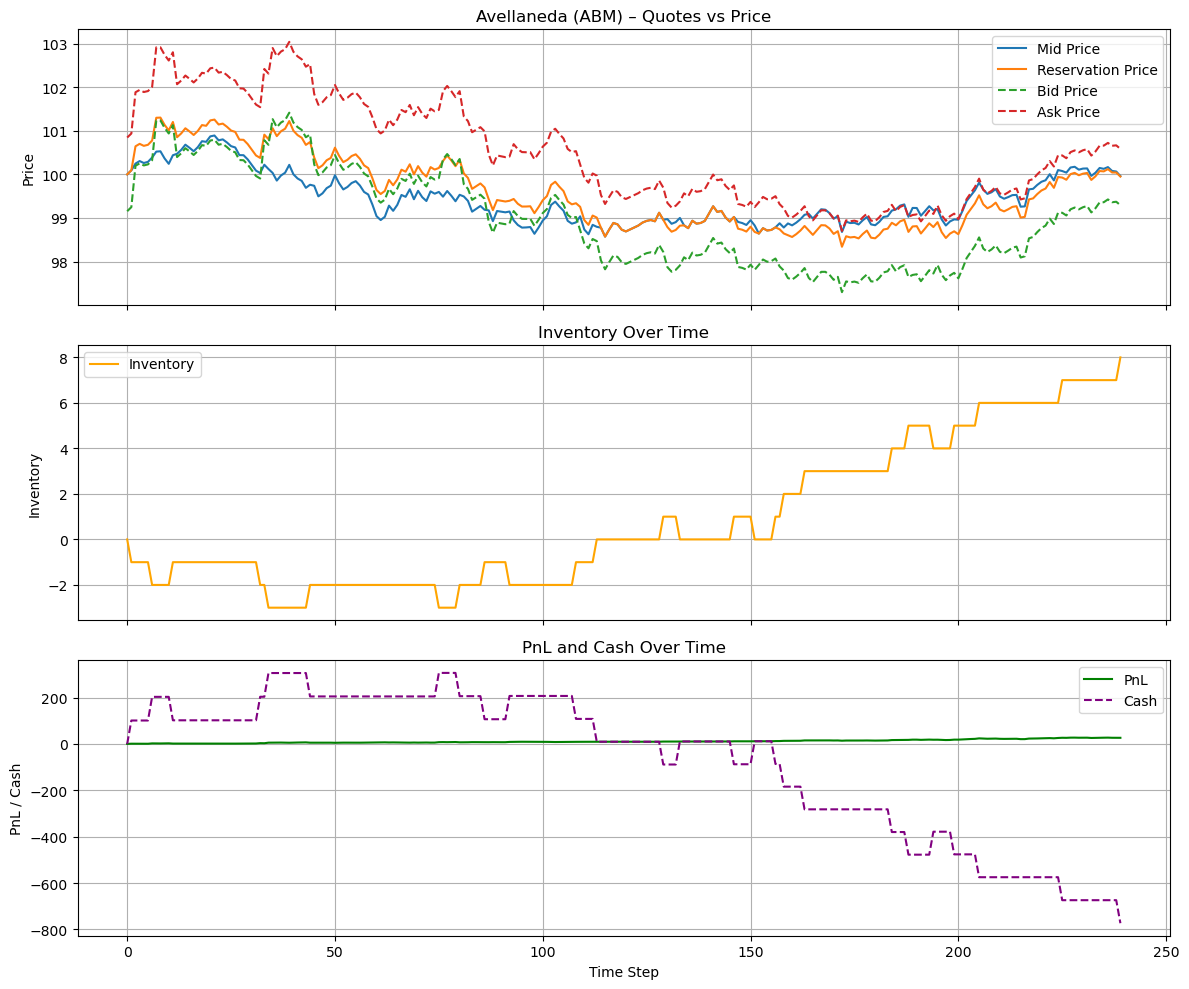

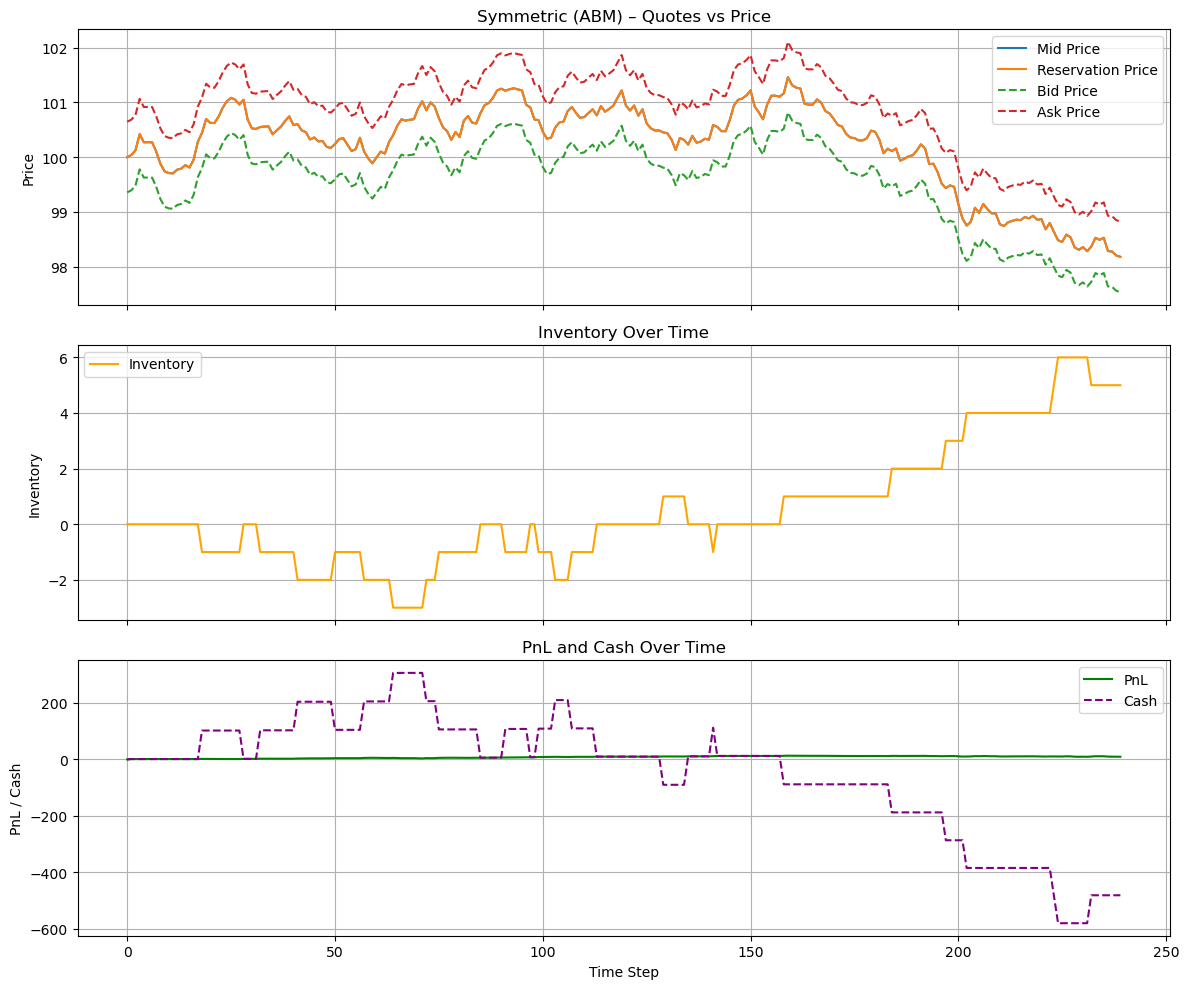

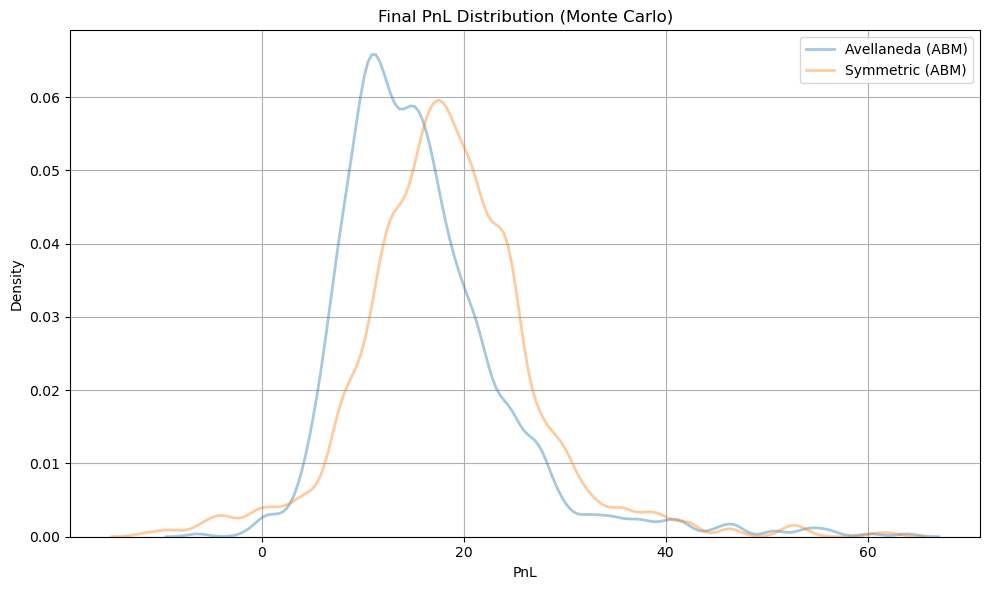


Summary Statistics (Final PnL):
                       mean       std    sharpe
strategy                                       
Avellaneda (ABM)  15.788974  8.288592  1.904904
Symmetric (ABM)   18.342122  8.568086  2.140749


In [6]:
main()

In [3]:
def main():
    import itertools

    # Simulation control
    steps = 240
    dt = 1 / 240.0
    n_simulations = 1000
    show_plots = True
    run_mc = True

    # Parameter sweep
    gamma_values = [0.01, 0.1, 0.5]
    sigma_values = [1.0, 2.0]
    k_values = [1.0, 1.5]

    # Strategy configs
    strategy_configs = [
        {
            "name": "Avellaneda",
            "market": "ABM",
            "simulator": ArithmeticBrownianMotion,
            "strategy_class": AvellanedaStoikovStrategyAbm,
            "execution_class": PoissonExecutionAbm
        },
        {
            "name": "Symmetric",
            "market": "ABM",
            "simulator": ArithmeticBrownianMotion,
            "strategy_class": SymmetricStrategy,
            "execution_class": PoissonExecutionAbm
        }
    ]

    # ----------------------
    # SINGLE-RUN SIMULATION
    # ----------------------
    if show_plots:
        df = run_strategy(
            simulator=ArithmeticBrownianMotion,
            strategy_class=AvellanedaStoikovStrategyAbm,
            execution_class=PoissonExecutionAbm,
            strategy_name="Avellaneda",
            market_name="ABM",
            steps=steps,
            dt=dt,
            gamma=0.1,
            k=1.5,
            sigma=2.0,
            seed=None
        )
        plot_strategy_diagnostics(df, "Avellaneda (γ=0.1, σ=2.0, k=1.5)")

    # ----------------------
    # MONTE CARLO SWEEP
    # ----------------------
    if run_mc:
        mc_records = []

        for gamma, sigma, k in itertools.product(gamma_values, sigma_values, k_values):
            for config in strategy_configs:
                strategy_label = f"{config['name']} γ={gamma}, σ={sigma}, k={k}"
                df_mc = run_monte_carlo(
                    simulator=config["simulator"],
                    strategy_class=config["strategy_class"],
                    execution_class=config["execution_class"],
                    strategy_name=strategy_label,
                    market_name=config["market"],
                    steps=steps,
                    dt=dt,
                    gamma=gamma,
                    k=k,
                    sigma=sigma,
                    n_simulations=n_simulations
                )
                df_mc["gamma"] = gamma
                df_mc["sigma"] = sigma
                df_mc["k"] = k
                df_mc["strategy_base"] = config["name"]
                mc_records.append(df_mc)

        df_all = pd.concat(mc_records, ignore_index=True)
        df_all.to_csv("Monte_Carlo_Simulation.csv")

        # --- Summary Table ---
        summary = (
            df_all.groupby(["strategy_base", "gamma", "sigma", "k"])["pnl"]
            .agg(mean="mean", std="std")
            .assign(sharpe=lambda df: df["mean"] / df["std"])
            .reset_index()
        )

        print("\nSummary Statistics (Final PnL):")
        print(summary.round(2))

        # --- Plot: Mean ± Std PnL ---
        plt.figure(figsize=(14, 6))
        bar_labels = [
            f"{row.strategy_base}\nγ={row.gamma}, σ={row.sigma}, k={row.k}"
            for _, row in summary.iterrows()
        ]
        plt.bar(
            bar_labels,
            summary["mean"],
            yerr=summary["std"],
            capsize=4,
            color="lightblue",
            edgecolor="black"
        )
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Mean Final PnL ± Std")
        plt.title("Monte Carlo Final PnL Across Parameter Settings")
        plt.grid(axis="y")
        plt.tight_layout()
        plt.show()


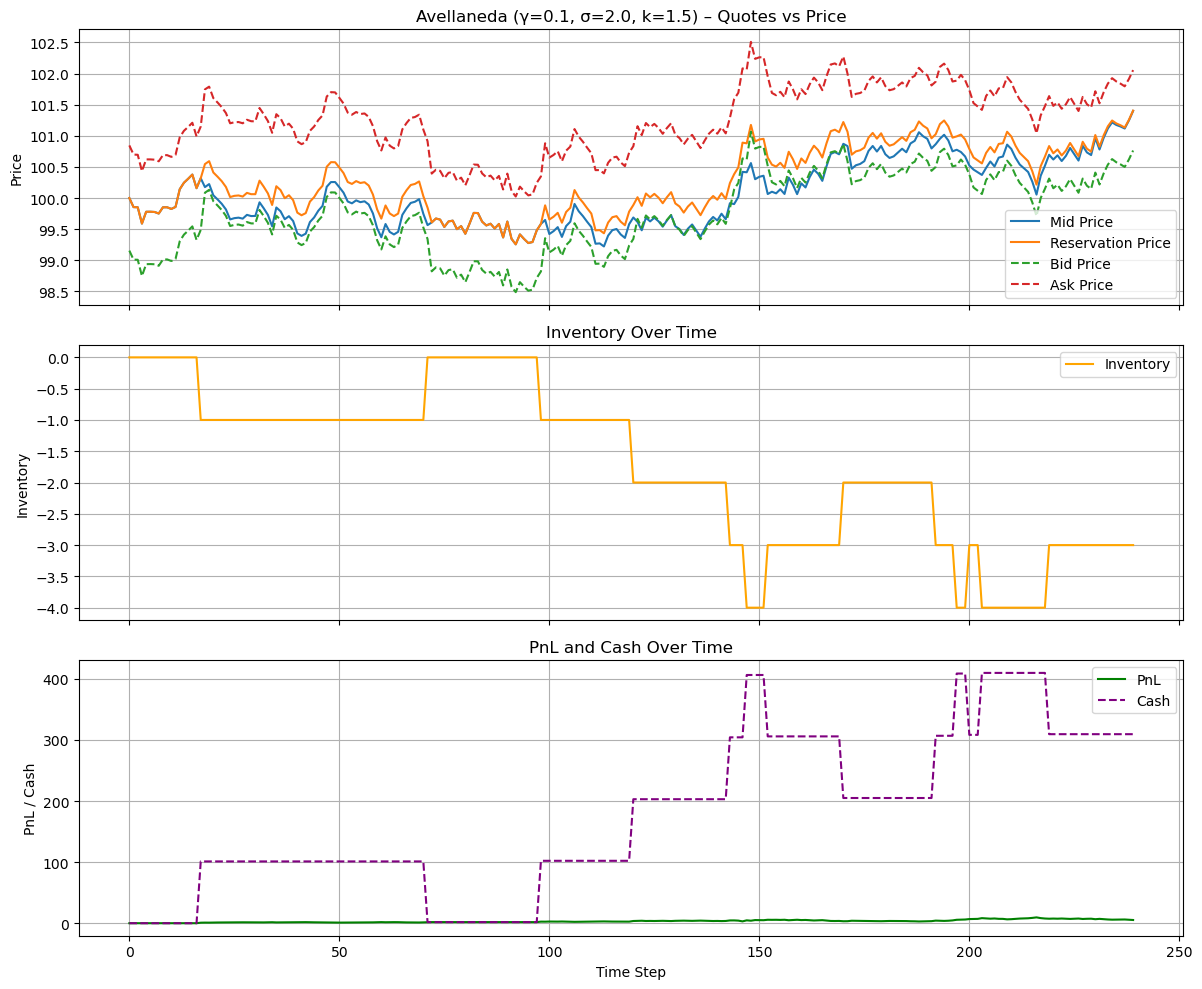


Summary Statistics (Final PnL):
   strategy_base  gamma  sigma    k   mean    std  sharpe
0     Avellaneda   0.01    1.0  1.0  27.11   6.13    4.42
1     Avellaneda   0.01    1.0  1.5  17.99   4.75    3.79
2     Avellaneda   0.01    2.0  1.0  26.61   9.09    2.93
3     Avellaneda   0.01    2.0  1.5  17.81   7.99    2.23
4     Avellaneda   0.10    1.0  1.0  27.63   6.51    4.25
5     Avellaneda   0.10    1.0  1.5  17.85   4.81    3.71
6     Avellaneda   0.10    2.0  1.0  25.28   9.49    2.66
7     Avellaneda   0.10    2.0  1.5  15.64   7.89    1.98
8     Avellaneda   0.50    1.0  1.0  28.28   9.20    3.07
9     Avellaneda   0.50    1.0  1.5  16.98   7.79    2.18
10    Avellaneda   0.50    2.0  1.0  18.96  12.77    1.49
11    Avellaneda   0.50    2.0  1.5   9.87   8.68    1.14
12     Symmetric   0.01    1.0  1.0  27.07   6.14    4.41
13     Symmetric   0.01    1.0  1.5  17.93   4.84    3.71
14     Symmetric   0.01    2.0  1.0  27.09   9.02    3.00
15     Symmetric   0.01    2.0  1.5  17

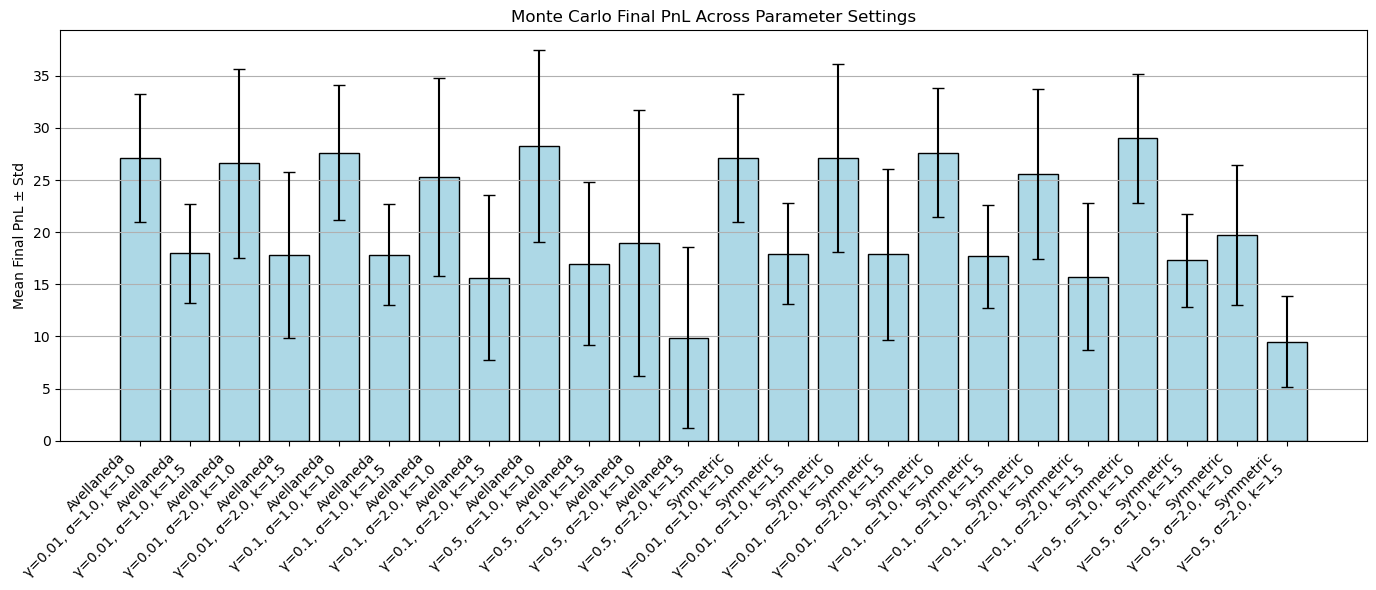

In [4]:
main()

In [8]:
def load_summary_from_csv(csv_path="Monte_Carlo_Simulation.csv"):
    """
    Load the previously saved Monte Carlo simulation CSV
    and compute the summary statistics (mean, std, Sharpe).
    """
    df_all = pd.read_csv(csv_path)

    # Extract base strategy from label if needed
    if "strategy_base" not in df_all.columns:
        df_all["strategy_base"] = df_all["strategy"].str.extract(r"^(Avellaneda|Symmetric)")

    summary = (
        df_all.groupby(["strategy_base", "gamma", "sigma", "k"])["pnl"]
        .agg(mean="mean", std="std")
        .assign(sharpe=lambda df: df["mean"] / df["std"])
        .reset_index()
    )

    print("\nLoaded Summary Statistics (Final PnL):")
    print(summary.round(2))

    return summary



Loaded Summary Statistics (Final PnL):
   strategy_base  gamma  sigma    k   mean    std  sharpe
0     Avellaneda   0.01    1.0  1.0  27.11   6.13    4.42
1     Avellaneda   0.01    1.0  1.5  17.99   4.75    3.79
2     Avellaneda   0.01    2.0  1.0  26.61   9.09    2.93
3     Avellaneda   0.01    2.0  1.5  17.81   7.99    2.23
4     Avellaneda   0.10    1.0  1.0  27.63   6.51    4.25
5     Avellaneda   0.10    1.0  1.5  17.85   4.81    3.71
6     Avellaneda   0.10    2.0  1.0  25.28   9.49    2.66
7     Avellaneda   0.10    2.0  1.5  15.64   7.89    1.98
8     Avellaneda   0.50    1.0  1.0  28.28   9.20    3.07
9     Avellaneda   0.50    1.0  1.5  16.98   7.79    2.18
10    Avellaneda   0.50    2.0  1.0  18.96  12.77    1.49
11    Avellaneda   0.50    2.0  1.5   9.87   8.68    1.14
12     Symmetric   0.01    1.0  1.0  27.07   6.14    4.41
13     Symmetric   0.01    1.0  1.5  17.93   4.84    3.71
14     Symmetric   0.01    2.0  1.0  27.09   9.02    3.00
15     Symmetric   0.01    2.0  

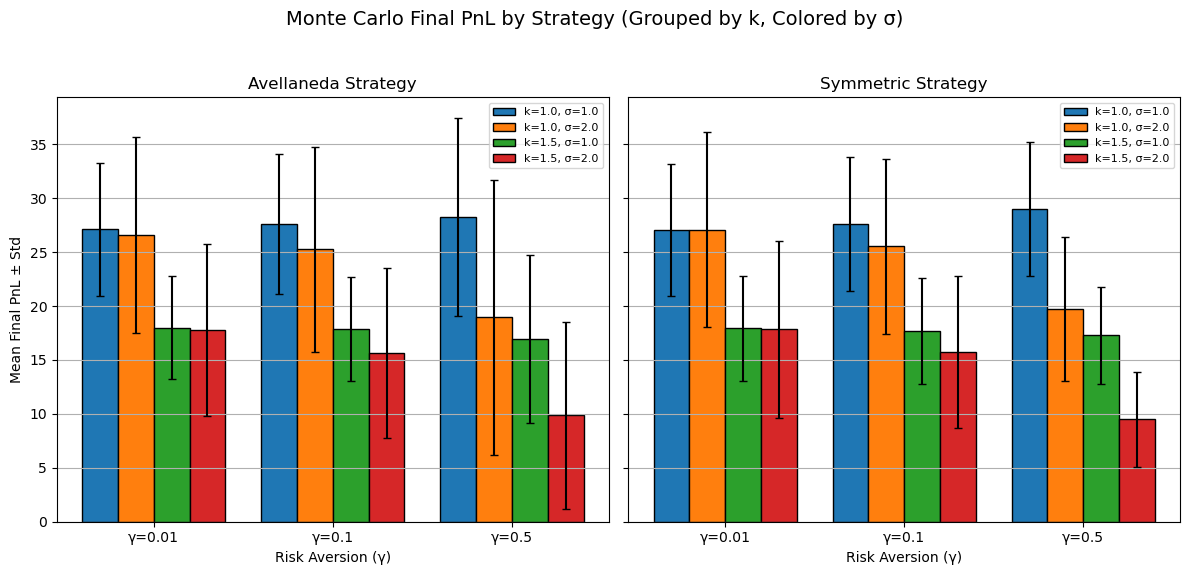

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

summary = load_summary_from_csv()

# --- Plot: One panel per strategy, grouped by k, colored by sigma ---
gks = summary["k"].unique()
sigmas = summary["sigma"].unique()
gammas = sorted(summary["gamma"].unique())
strategies = summary["strategy_base"].unique()

fig, axs = plt.subplots(1, len(strategies), figsize=(6 * len(strategies), 6), sharey=True)

for ax, strategy in zip(axs, strategies):
    sub_df = summary[summary["strategy_base"] == strategy]
    
    width = 0.2  # bar width
    x_base = np.arange(len(gammas))  # x positions for each γ

    for i, k_val in enumerate(gks):
        for j, sigma_val in enumerate(sigmas):
            df_k_sigma = sub_df[(sub_df["k"] == k_val) & (sub_df["sigma"] == sigma_val)]

            # Sort by gamma for alignment
            df_k_sigma = df_k_sigma.sort_values(by="gamma")
            means = df_k_sigma["mean"].values
            stds = df_k_sigma["std"].values
            x_pos = x_base + (i * len(sigmas) + j - 1.5) * width

            label = f"k={k_val}, σ={sigma_val}"
            ax.bar(x_pos, means, width=width, yerr=stds, capsize=3, label=label, edgecolor="black")

    ax.set_xticks(x_base)
    ax.set_xticklabels([f"γ={g}" for g in gammas])
    ax.set_title(f"{strategy} Strategy")
    ax.set_xlabel("Risk Aversion (γ)")
    ax.grid(axis="y")
    if ax == axs[0]:
        ax.set_ylabel("Mean Final PnL ± Std")

    ax.legend(fontsize=8, loc="upper right")

plt.suptitle("Monte Carlo Final PnL by Strategy (Grouped by k, Colored by σ)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



Standard Deviation of PnL vs Gamma (σ=2.0, k=1.5):
  strategy_base  gamma   std
0    Avellaneda   0.01  7.41
1    Avellaneda   0.10  7.76
2    Avellaneda   0.50  8.70
3     Symmetric   0.01  7.72
4     Symmetric   0.10  7.44
5     Symmetric   0.50  4.69


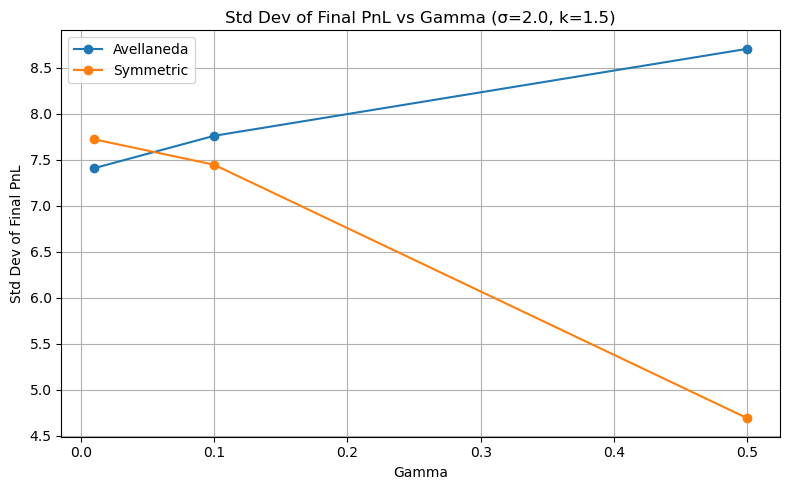

In [10]:
def main():
    import itertools

    # Simulation control
    steps = 240
    dt = 1 / 240.0
    n_simulations = 1000
    show_plots = False
    run_mc = True

    # Parameter sweep
    gamma_values = [0.01, 0.1, 0.5]
    sigma_values = [2.0]  # fixed
    k_values = [1.5]      # fixed

    # Strategy configs
    strategy_configs = [
        {
            "name": "Avellaneda",
            "market": "ABM",
            "simulator": ArithmeticBrownianMotion,
            "strategy_class": AvellanedaStoikovStrategyAbm,
            "execution_class": PoissonExecutionAbm
        },
        {
            "name": "Symmetric",
            "market": "ABM",
            "simulator": ArithmeticBrownianMotion,
            "strategy_class": SymmetricStrategy,
            "execution_class": PoissonExecutionAbm
        }
    ]

    if run_mc:
        mc_records = []

        for gamma, sigma, k in itertools.product(gamma_values, sigma_values, k_values):
            for config in strategy_configs:
                strategy_label = f"{config['name']} γ={gamma}, σ={sigma}, k={k}"
                df_mc = run_monte_carlo(
                    simulator=config["simulator"],
                    strategy_class=config["strategy_class"],
                    execution_class=config["execution_class"],
                    strategy_name=strategy_label,
                    market_name=config["market"],
                    steps=steps,
                    dt=dt,
                    gamma=gamma,
                    k=k,
                    sigma=sigma,
                    n_simulations=n_simulations
                )
                df_mc["gamma"] = gamma
                df_mc["sigma"] = sigma
                df_mc["k"] = k
                df_mc["strategy_base"] = config["name"]
                mc_records.append(df_mc)

        df_all = pd.concat(mc_records, ignore_index=True)

        # Filter: sigma = 2.0, k = 1.5
        df_filtered = df_all[(df_all["sigma"] == 2.0) & (df_all["k"] == 1.5)]

        # Compute std_pnl vs gamma
        summary = (
            df_filtered.groupby(["strategy_base", "gamma"])["pnl"]
            .agg(std="std")
            .reset_index()
        )

        print("\nStandard Deviation of PnL vs Gamma (σ=2.0, k=1.5):")
        print(summary.round(2))

        # Plot: std PnL vs gamma
        plt.figure(figsize=(8, 5))
        for strat in summary["strategy_base"].unique():
            sub = summary[summary["strategy_base"] == strat]
            plt.plot(sub["gamma"], sub["std"], marker='o', label=strat)

        plt.title("Std Dev of Final PnL vs Gamma (σ=2.0, k=1.5)")
        plt.xlabel("Gamma")
        plt.ylabel("Std Dev of Final PnL")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
main()

In [ ]:
# -------------------------------------------------------
# Strict Paper-style Reproduction for γ ∈ {0.01, 0.1, 0.5}
# -------------------------------------------------------
def reproduce_avellaneda_stoikov_paper_experiment():
    gammas = [0.01, 0.1, 0.5]
    steps = 240
    dt = 1 / 240.0
    sigma = 2.0
    k = 1.5
    n_simulations = 1000

    all_records = []
    for gamma in gammas:
        for strategy_type, strategy_class in [
            ("Inventory", AvellanedaStoikovStrategyAbm),
            ("Symmetric", SymmetricStrategy),
        ]:
            df = run_monte_carlo(
                simulator=ArithmeticBrownianMotion,
                strategy_class=strategy_class,
                execution_class=PoissonExecutionAbm,
                strategy_name=f"{strategy_type} γ={gamma}",
                market_name="ABM",
                steps=steps,
                dt=dt,
                gamma=gamma,
                k=k,
                sigma=sigma,
                n_simulations=n_simulations
            )
            df["gamma"] = gamma
            all_records.append(df)

    results = pd.concat(all_records, ignore_index=True)

    # Histogram plot with two colors per gamma
    color_map = {"Inventory": "#1f77b4", "Symmetric": "#ff7f0e"}

    for gamma_val, df_gamma in results.groupby("gamma"):
        plt.figure(figsize=(10, 6))
        for label, grp in df_gamma.groupby("strategy"):
            strategy_type = "Inventory" if "Inventory" in label else "Symmetric"
            plt.hist(
                grp["pnl"],
                bins=50,
                alpha=0.6,
                label=label,
                color=color_map[strategy_type],
                edgecolor="black",
                linewidth=0.6,
                density=True
            )
        plt.title(f"Final PnL Distribution (γ = {gamma_val}) – Histogram")
        plt.xlabel("Final PnL")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Summary stats
    summary = (
        results.groupby("strategy")
        .agg(mean_pnl=("pnl", "mean"),
             std_pnl=("pnl", "std"),
             mean_q=("inventory", "mean"),
             std_q=("inventory", "std"))
        .assign(sharpe=lambda df: df["mean_pnl"] / df["std_pnl"])
        .reset_index()
    )

    print("\nSummary Statistics:")
    print(summary.round(2))


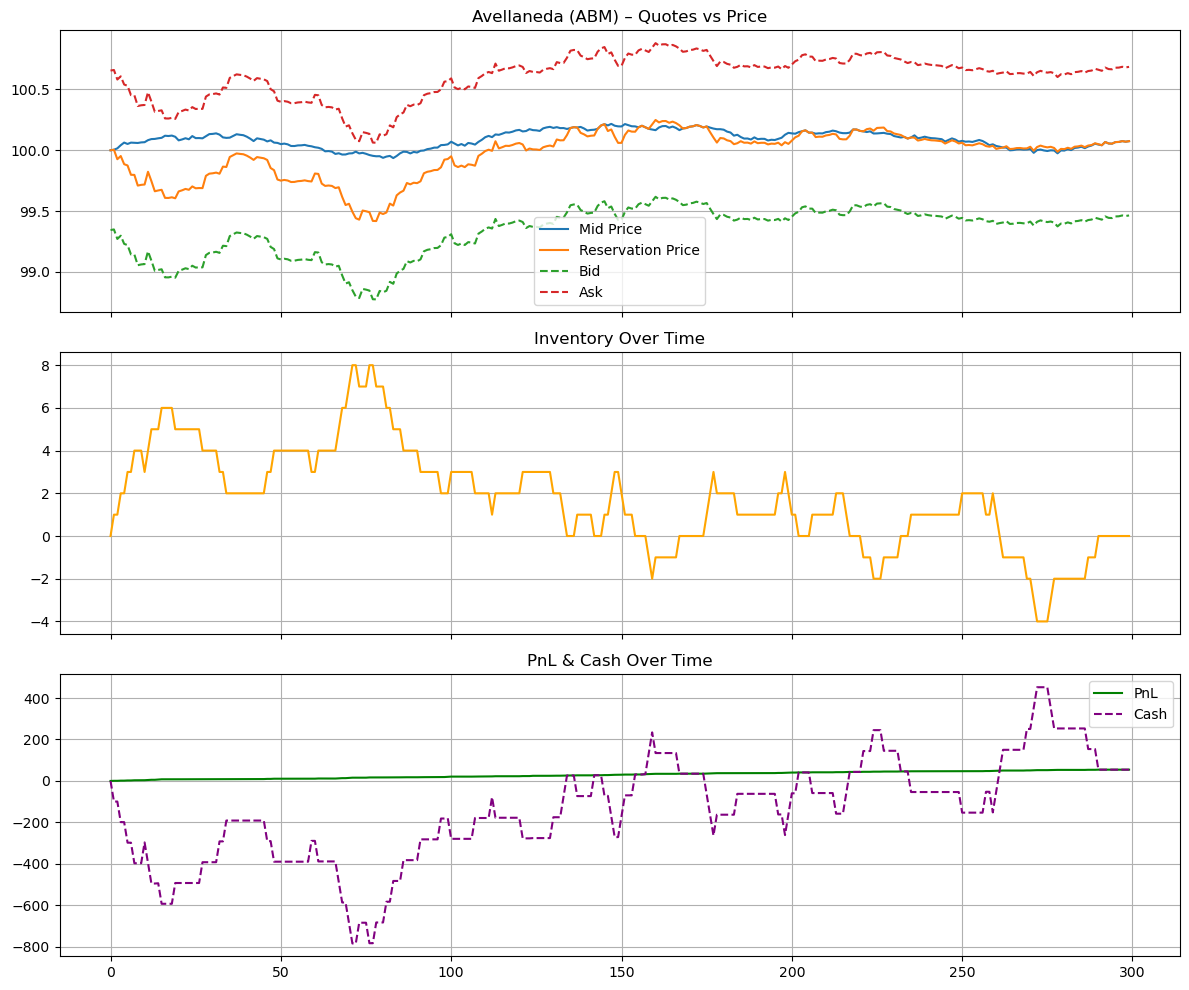

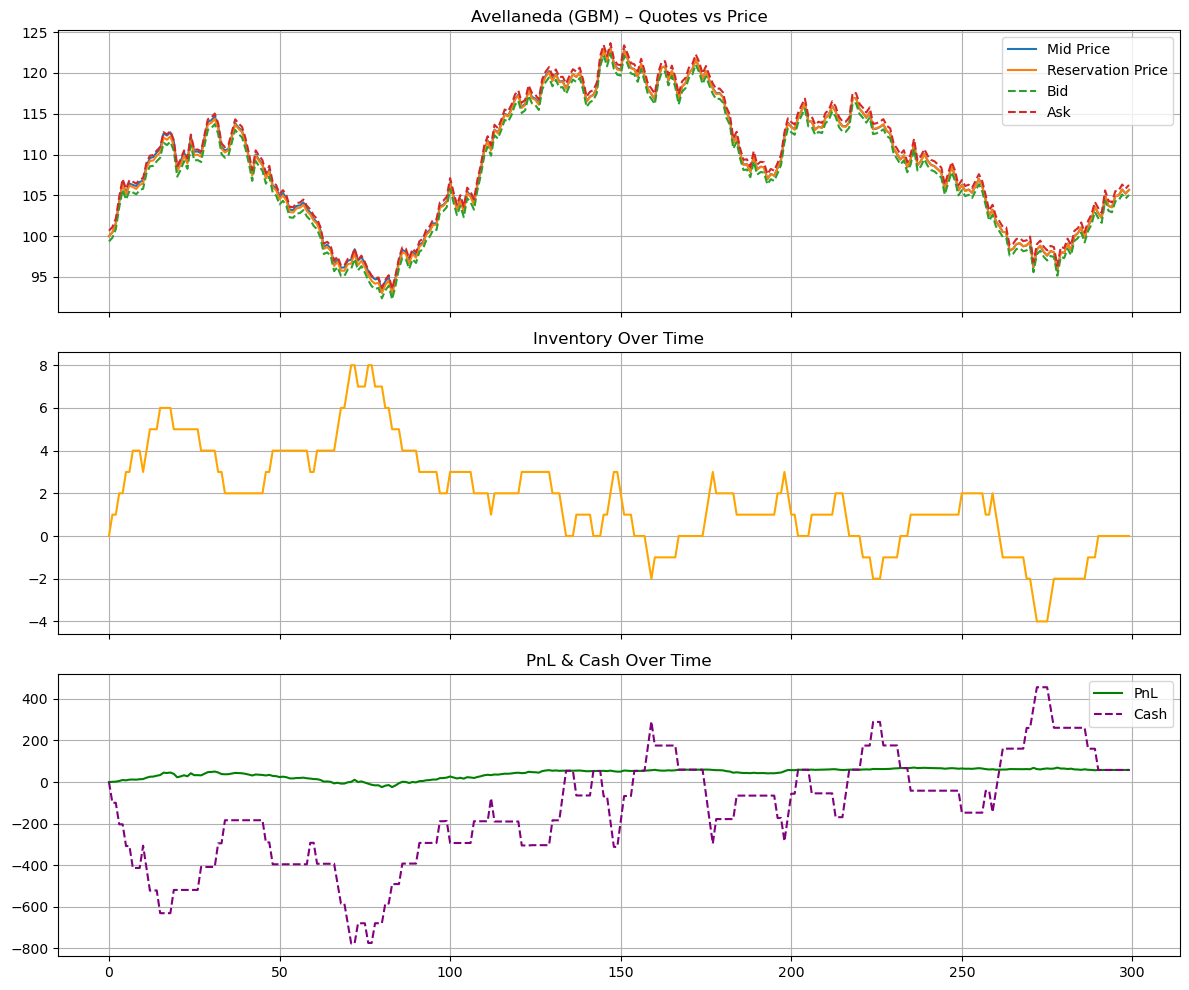

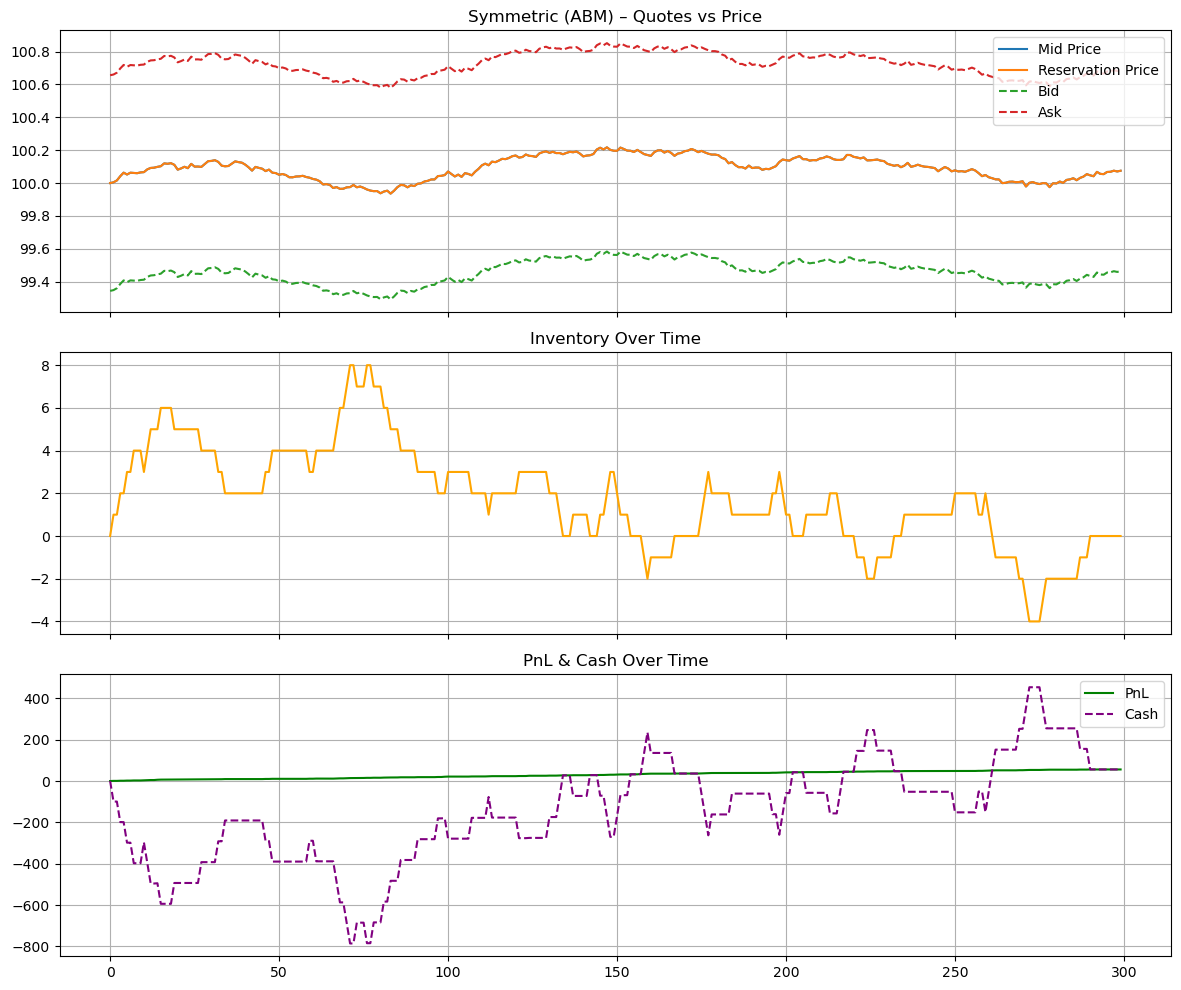

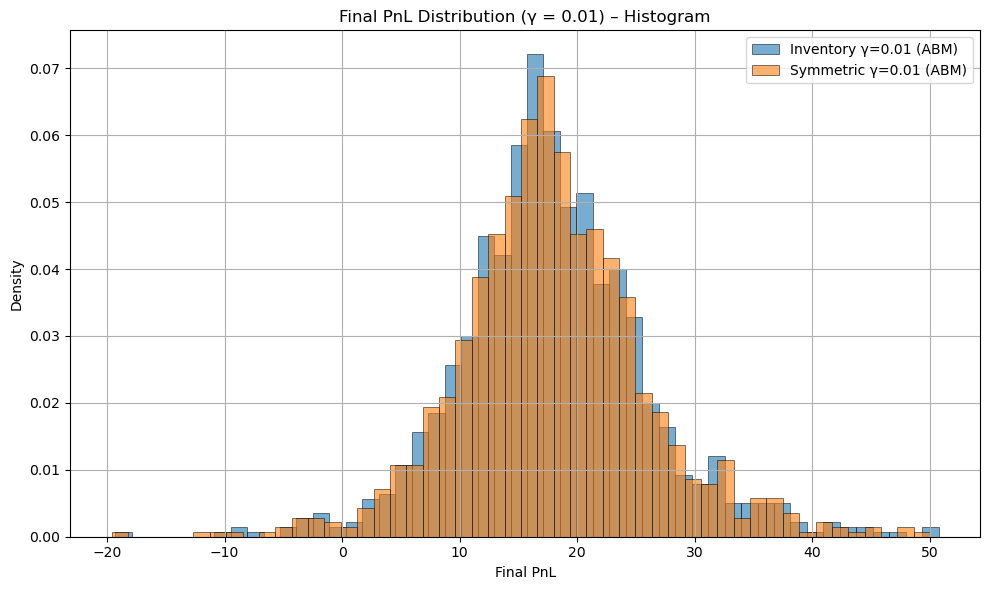

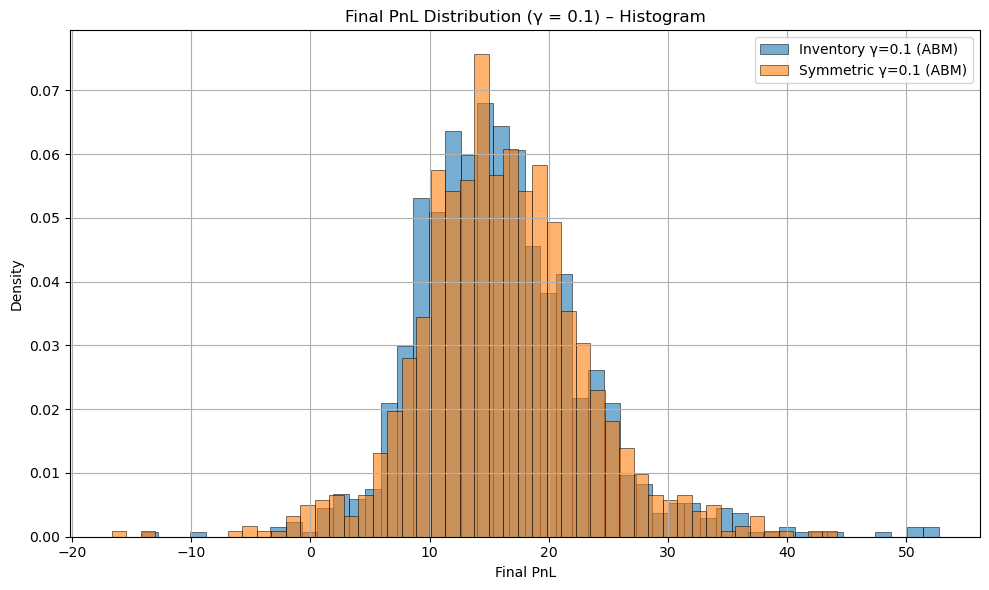

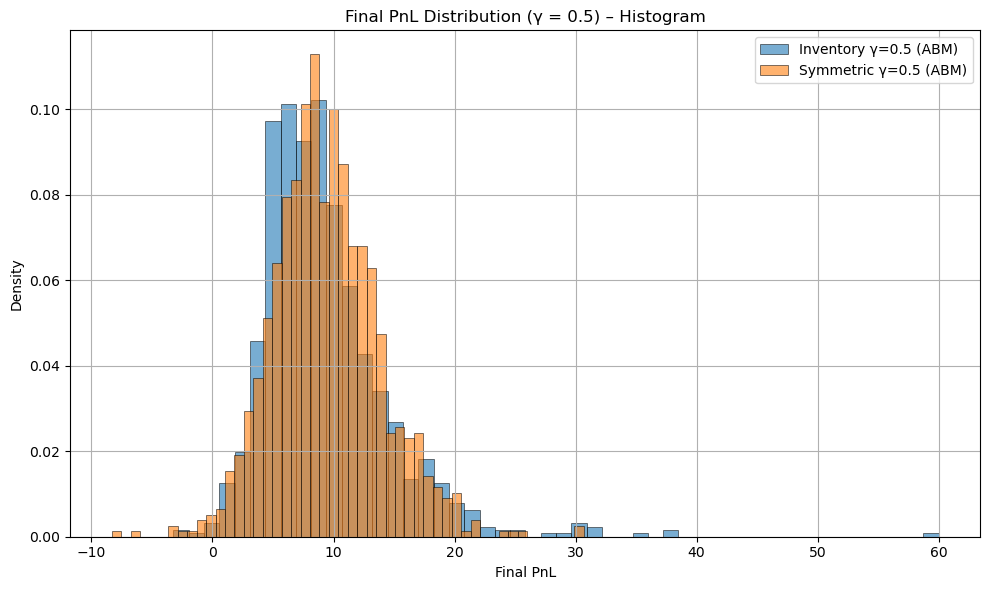


Summary Statistics:
                 strategy  mean_pnl  std_pnl  mean_q  std_q  sharpe
0  Inventory γ=0.01 (ABM)     17.88     8.10    0.09   4.99    2.21
1   Inventory γ=0.1 (ABM)     15.95     7.26    0.06   4.49    2.20
2   Inventory γ=0.5 (ABM)      9.30     5.30    0.11   3.23    1.75
3  Symmetric γ=0.01 (ABM)     17.88     8.10    0.09   4.99    2.21
4   Symmetric γ=0.1 (ABM)     16.03     7.00    0.06   4.49    2.29
5   Symmetric γ=0.5 (ABM)      9.42     4.44    0.11   3.23    2.12


In [ ]:
if __name__ == "__main__":
    main()
    reproduce_avellaneda_stoikov_paper_experiment()
